In [1]:
#!pip install shap

In [2]:
#!pip install catboost

In [3]:
# Manipulation des données
import pandas as pd
import numpy as np

# Visualisation de données
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, cross_val_predict, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, make_scorer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from catboost import CatBoostRegressor
from sklearn.base import BaseEstimator, TransformerMixin

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import sparse
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA
from scipy.stats import chi2_contingency



import shap

# Affichage des graphiques dans le notebook
%matplotlib inline

# Configuration des graphiques
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

pd.set_option('display.max_columns', None)

In [4]:
df = pd.read_csv('2016-building-energy.csv')
df.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,60.0,81.699997,84.300003,182.500000,189.000000,7226362.5,7456910.0,2003882.00,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,61.0,94.800003,97.900002,176.100006,179.399994,8387933.0,8664479.0,0.00,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,7,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,956110,196718,759392,Hotel,Hotel,756493.0,NaN,NaN,NaN,NaN,NaN,43.0,96.000000,97.699997,241.899994,244.100006,72587024.0,73937112.0,21566554.00,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,7,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,NaN,56.0,110.800003,113.300003,216.199997,224.000000,6794584.0,6946800.5,2214446.25,8.115253e+05,2768924.0,18112.13086,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,7,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,NaN,75.0,114.800003,118.699997,211.399994,215.600006,14172606.0,14656503.0,0.00,1.573449e+06,5368607.0,88039.98438,8803998.0,False,NaN,Compliant,NaN,505.01,2.88


# EDA / Analyse

## EDA

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

In [6]:
df.describe()

,OSEBuildingID,DataYear,ZipCode,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),Comments,TotalGHGEmissions,GHGEmissionsIntensity
count,3376.000000,3376.0,3360.000000,3376.000000,3376.000000,3376.000000,3376.000000,3368.000000,3376.000000,3.376000e+03,3376.000000,3.376000e+03,3.356000e+03,1679.000000,596.000000,2533.000000,3369.000000,3370.000000,3367.000000,3367.000000,3.371000e+03,3.370000e+03,3.367000e+03,3.367000e+03,3.367000e+03,3.367000e+03,3.367000e+03,0.0,3367.000000,3367.000000
mean,21208.991114,2016.0,98116.949107,4.439277,47.624033,-122.334795,1968.573164,1.106888,4.709123,9.483354e+04,8001.526066,8.683201e+04,7.917764e+04,28444.075817,11738.675166,67.918674,54.732116,57.033798,134.232848,137.783932,5.403667e+06,5.276726e+06,2.745959e+05,1.086639e+06,3.707612e+06,1.368505e+04,1.368505e+06,NaN,119.723971,1.175916
std,12223.757015,0.0,18.615205,2.120625,0.047758,0.027203,33.088156,2.108402,5.494465,2.188376e+05,32326.723928,2.079398e+05,2.017034e+05,54392.917928,29331.199286,26.873271,56.273124,57.163330,139.287554,139.109807,2.161063e+07,1.593879e+07,3.912173e+06,4.352478e+06,1.485066e+07,6.709781e+04,6.709781e+06,NaN,538.832227,1.821452
min,1.000000,2016.0,98006.000000,1.000000,47.499170,-122.414250,1900.000000,0.000000,0.000000,1.128500e+04,0.000000,3.636000e+03,5.656000e+03,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-2.100000,0.000000e+00,0.000000e+00,0.000000e+00,-3.382680e+04,-1.154170e+05,0.000000e+00,0.000000e+00,NaN,-0.800000,-0.020000
25%,19990.750000,2016.0,98105.000000,3.000000,47.599860,-122.350662,1948.000000,1.000000,2.000000,2.848700e+04,0.000000,2.775600e+04,2.509475e+04,5000.000000,2239.000000,53.000000,27.900000,29.400000,74.699997,78.400002,9.251286e+05,9.701822e+05,0.000000e+00,1.874229e+05,6.394870e+05,0.000000e+00,0.000000e+00,NaN,9.495000,0.210000
50%,23112.000000,2016.0,98115.000000,4.000000,47.618675,-122.332495,1975.000000,1.000000,4.000000,4.417500e+04,0.000000,4.321600e+04,3.989400e+04,10664.000000,5043.000000,75.000000,38.599998,40.900002,96.199997,101.099998,1.803753e+06,1.904452e+06,0.000000e+00,3.451299e+05,1.177583e+06,3.237538e+03,3.237540e+05,NaN,33.920000,0.610000
75%,25994.250000,2016.0,98122.000000,7.000000,47.657115,-122.319407,1997.000000,1.000000,5.000000,9.099200e+04,0.000000,8.427625e+04,7.620025e+04,26640.000000,10138.750000,90.000000,60.400002,64.275002,143.899994,148.349998,4.222455e+06,4.381429e+06,0.000000e+00,8.293178e+05,2.829632e+06,1.189033e+04,1.189034e+06,NaN,93.940000,1.370000
max,50226.000000,2016.0,98272.000000,7.000000,47.733870,-122.220966,2015.000000,111.000000,99.000000,9.320156e+06,512608.000000,9.320156e+06,9.320156e+06,686750.000000,459748.000000,100.000000,834.400024,834.400024,2620.000000,2620.000000,8.739237e+08,4.716139e+08,1.349435e+08,1.925775e+08,6.570744e+08,2.979090e+06,2.979090e+08,NaN,16870.980000,34.090000


In [7]:
df.isnull().sum()

OSEBuildingID                         0
DataYear                              0
BuildingType                          0
PrimaryPropertyType                   0
PropertyName                          0
Address                               0
City                                  0
State                                 0
ZipCode                              16
TaxParcelIdentificationNumber         0
CouncilDistrictCode                   0
Neighborhood                          0
Latitude                              0
Longitude                             0
YearBuilt                             0
NumberofBuildings                     8
NumberofFloors                        0
PropertyGFATotal                      0
PropertyGFAParking                    0
PropertyGFABuilding(s)                0
ListOfAllPropertyUseTypes             9
LargestPropertyUseType               20
LargestPropertyUseTypeGFA            20
SecondLargestPropertyUseType       1697
SecondLargestPropertyUseTypeGFA    1697


In [8]:
df['ComplianceStatus'].unique()

array(['Compliant', 'Error - Correct Default Data', 'Missing Data',
       'Non-Compliant'], dtype=object)

In [9]:
df['PrimaryPropertyType'].unique()

array(['Hotel', 'Other', 'Mid-Rise Multifamily', 'Mixed Use Property',
       'K-12 School', 'University', 'Small- and Mid-Sized Office',
       'Self-Storage Facility', 'Warehouse', 'Large Office',
       'Senior Care Community', 'Medical Office', 'Retail Store',
       'Hospital', 'Residence Hall', 'Distribution Center',
       'Worship Facility', 'Low-Rise Multifamily',
       'Supermarket / Grocery Store', 'Laboratory',
       'Refrigerated Warehouse', 'Restaurant', 'High-Rise Multifamily',
       'Office'], dtype=object)

In [10]:
df['BuildingType'].unique()

array(['NonResidential', 'Nonresidential COS', 'Multifamily MR (5-9)',
       'SPS-District K-12', 'Campus', 'Multifamily LR (1-4)',
       'Multifamily HR (10+)', 'Nonresidential WA'], dtype=object)

In [11]:
df['Neighborhood'].unique()

array(['DOWNTOWN', 'SOUTHEAST', 'NORTHEAST', 'EAST', 'Central', 'NORTH',
       'MAGNOLIA / QUEEN ANNE', 'LAKE UNION', 'GREATER DUWAMISH',
       'BALLARD', 'NORTHWEST', 'CENTRAL', 'SOUTHWEST', 'DELRIDGE',
       'Ballard', 'North', 'Delridge', 'Northwest',
       'DELRIDGE NEIGHBORHOODS'], dtype=object)

In [12]:
df.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
3371    False
3372    False
3373    False
3374    False
3375    False
Length: 3376, dtype: bool

In [13]:
df.drop_duplicates()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,60.0,81.699997,84.300003,182.500000,189.000000,7.226362e+06,7.456910e+06,2003882.00,1.156514e+06,3.946027e+06,12764.529300,1.276453e+06,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,61.0,94.800003,97.900002,176.100006,179.399994,8.387933e+06,8.664479e+06,0.00,9.504252e+05,3.242851e+06,51450.816410,5.145082e+06,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,7,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,956110,196718,759392,Hotel,Hotel,756493.0,NaN,NaN,NaN,NaN,NaN,43.0,96.000000,97.699997,241.899994,244.100006,7.258702e+07,7.393711e+07,21566554.00,1.451544e+07,4.952666e+07,14938.000000,1.493800e+06,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,7,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,NaN,56.0,110.800003,113.300003,216.199997,224.000000,6.794584e+06,6.946800e+06,2214446.25,8.115253e+05,2.768924e+06,18112.130860,1.811213e+06,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,7,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,NaN,75.0,114.800003,118.699997,211.399994,215.600006,1.417261e+07,1.465650e+07,0.00,1.573449e+06,5.368607e+06,88039.984380,8.803998e+06,False,NaN,Compliant,NaN,505.01,2.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,50222,2016,Nonresidential COS,Office,Horticulture building,1600 S Dakota St,Seattle,WA,NaN,1624049080,2,GREATER DUWAMISH,47.56722,-122.31154,1990,1.0,1,12294,0,12294,Office,Office,12294.0,NaN,NaN,NaN,NaN,NaN,46.0,69.099998,76.699997,161.699997,176.100006,8.497457e+05,9.430032e+05,0.00,1.536550e+05,5.242709e+05,3254.750244,3.254750e+05,True,NaN,Error - Correct Default Data,NaN,20.94,1.70
3372,50223,2016,Nonresidential COS,Other,International district/Chinatown CC,719 8th Ave S,Seattle,WA,NaN,3558300000,2,DOWNTOWN,47.59625,-122.32283,2004,1.0,1,16000,0,16000,Other - Recreation,Other - Recreation,16000.0,NaN,NaN,NaN,NaN,NaN,NaN,59.400002,65.900002,114.199997,118.900002,9.502762e+05,1.053706e+06,0.00,1.162210e+05,3.965461e+05,5537.299805,5.537300e+05,False,NaN,Compliant,NaN,32.17,2.01
3373,50224,2016,Nonresidential COS,Other,Queen Anne Pool,1920 1st Ave W,Seattle,WA,NaN,1794501150,7,MAGNOLIA / QUEEN ANNE,47.63644,-122.35784,1974,1.0,1,13157,0,13157,"Fitness Center/Health Club/Gym, Other - Recrea...",Other - Recreation,7583.0,Fitness Center/Health Club/Gym,5574.0,Swimmin

In [14]:
df["DefaultData"].value_counts()

False    3263
True      113
Name: DefaultData, dtype: int64

In [15]:
df["ComplianceStatus"].value_counts()

Compliant                       3211
Error - Correct Default Data     113
Non-Compliant                     37
Missing Data                      15
Name: ComplianceStatus, dtype: int64

In [16]:
# Dataset de 3376 lignes & 46 colonnes. Présence de NaN en grandes quantités dans certaines colonnes
# Supression des colonnes avec trop de NaN, remplacement des NaN si faible quantité
# Pas de doublon dans le Dataset. Des valeurs uniques en doublon dans "Neighborhood" (pas la même case)
# Possibilité de ne garder que le "BuildingType" et de grouper certaine "PrimaryPropertyType"
# On constaste que sur 113 lignes, des données par défaut ont été utilisées sans savoir où
# On a également 15 lignes avec du "Missing Data"

## Corrélation

In [17]:
# Sélectionner uniquement les colonnes numériques
numeric_df = df.select_dtypes(include=['int64', 'float64'])

# Ajouter la colonne cible pour l'analyse de corrélation
numeric_df['TotalGHGEmissions'] = df['TotalGHGEmissions']

# Calculer la matrice de corrélation
corr_matrix = numeric_df.corr()

# Extraire les corrélations avec TotalGHGEmissions
target_correlation = corr_matrix['TotalGHGEmissions'].sort_values(ascending=False)

# Convertir en DataFrame pour une meilleure lisibilité
TotalGHGEmissions_corr = target_correlation.to_frame(name='TotalGHGEmissions')

# Afficher les corrélations
TotalGHGEmissions_corr

,TotalGHGEmissions
TotalGHGEmissions,1.000000
SiteEnergyUse(kBtu),0.862668
SiteEnergyUseWN(kBtu),0.859042
NaturalGas(therms),0.732294
NaturalGas(kBtu),0.732294
Electricity(kWh),0.691111
Electricity(kBtu),0.691111
SteamUse(kBtu),0.683254
ThirdLargestPropertyUseTypeGFA,0.677722
LargestPropertyUseTypeGFA,0.578487


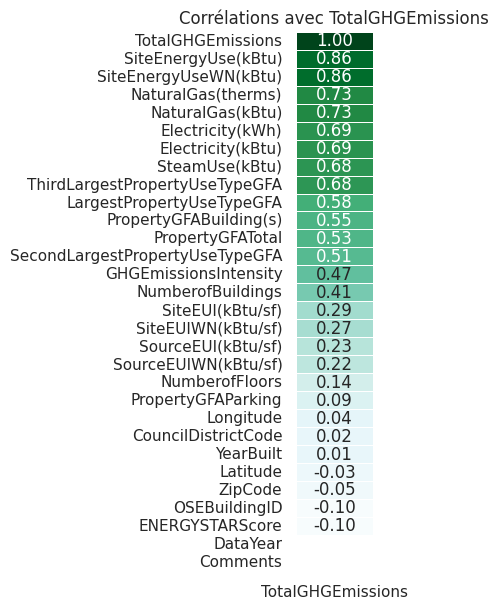

In [18]:
plt.figure(figsize=(1, 7))
sns.heatmap(TotalGHGEmissions_corr, annot=True, cmap='BuGn', fmt='.2f', linewidths=0.5, cbar=False)
plt.title('Corrélations avec TotalGHGEmissions')
plt.show()

In [19]:
# Corrélation élevé : > 0.6
# Corrélation modéré : entre 0.4 & 0.6
# Corrélation faible & neg : < 0.4

# On peut imaginer virer les corrélations faible & neg car elles n'apportent probablement
# pas beaucoup d'informations utiles pour prédire TotalGHGEmissions. A suivre !

## Nettoyage

In [20]:
replace = {
    'Delridge': 'DELRIDGE',
    'DELRIDGE NEIGHBORHOODS': 'DELRIDGE',
    'Ballard': 'BALLARD',
    'North': 'NORTH',
    'Northwest': 'NORTHWEST',
    'Central': 'CENTRAL',
}

df['Neighborhood'] = df['Neighborhood'].replace(replace)
df

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,60.0,81.699997,84.300003,182.500000,189.000000,7.226362e+06,7.456910e+06,2003882.00,1.156514e+06,3.946027e+06,12764.529300,1.276453e+06,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,61.0,94.800003,97.900002,176.100006,179.399994,8.387933e+06,8.664479e+06,0.00,9.504252e+05,3.242851e+06,51450.816410,5.145082e+06,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,7,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,956110,196718,759392,Hotel,Hotel,756493.0,NaN,NaN,NaN,NaN,NaN,43.0,96.000000,97.699997,241.899994,244.100006,7.258702e+07,7.393711e+07,21566554.00,1.451544e+07,4.952666e+07,14938.000000,1.493800e+06,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,7,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,NaN,56.0,110.800003,113.300003,216.199997,224.000000,6.794584e+06,6.946800e+06,2214446.25,8.115253e+05,2.768924e+06,18112.130860,1.811213e+06,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,7,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,NaN,75.0,114.800003,118.699997,211.399994,215.600006,1.417261e+07,1.465650e+07,0.00,1.573449e+06,5.368607e+06,88039.984380,8.803998e+06,False,NaN,Compliant,NaN,505.01,2.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,50222,2016,Nonresidential COS,Office,Horticulture building,1600 S Dakota St,Seattle,WA,NaN,1624049080,2,GREATER DUWAMISH,47.56722,-122.31154,1990,1.0,1,12294,0,12294,Office,Office,12294.0,NaN,NaN,NaN,NaN,NaN,46.0,69.099998,76.699997,161.699997,176.100006,8.497457e+05,9.430032e+05,0.00,1.536550e+05,5.242709e+05,3254.750244,3.254750e+05,True,NaN,Error - Correct Default Data,NaN,20.94,1.70
3372,50223,2016,Nonresidential COS,Other,International district/Chinatown CC,719 8th Ave S,Seattle,WA,NaN,3558300000,2,DOWNTOWN,47.59625,-122.32283,2004,1.0,1,16000,0,16000,Other - Recreation,Other - Recreation,16000.0,NaN,NaN,NaN,NaN,NaN,NaN,59.400002,65.900002,114.199997,118.900002,9.502762e+05,1.053706e+06,0.00,1.162210e+05,3.965461e+05,5537.299805,5.537300e+05,False,NaN,Compliant,NaN,32.17,2.01
3373,50224,2016,Nonresidential COS,Other,Queen Anne Pool,1920 1st Ave W,Seattle,WA,NaN,1794501150,7,MAGNOLIA / QUEEN ANNE,47.63644,-122.35784,1974,1.0,1,13157,0,13157,"Fitness Center/Health Club/Gym, Other - Recrea...",Other - Recreation,7583.0,Fitness Center/Health Club/Gym,5574.0,Swimmin

In [21]:
df_clean = df.dropna(subset=['TotalGHGEmissions'])
df_clean

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,60.0,81.699997,84.300003,182.500000,189.000000,7.226362e+06,7.456910e+06,2003882.00,1.156514e+06,3.946027e+06,12764.529300,1.276453e+06,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,61.0,94.800003,97.900002,176.100006,179.399994,8.387933e+06,8.664479e+06,0.00,9.504252e+05,3.242851e+06,51450.816410,5.145082e+06,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,7,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,956110,196718,759392,Hotel,Hotel,756493.0,NaN,NaN,NaN,NaN,NaN,43.0,96.000000,97.699997,241.899994,244.100006,7.258702e+07,7.393711e+07,21566554.00,1.451544e+07,4.952666e+07,14938.000000,1.493800e+06,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,7,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,NaN,56.0,110.800003,113.300003,216.199997,224.000000,6.794584e+06,6.946800e+06,2214446.25,8.115253e+05,2.768924e+06,18112.130860,1.811213e+06,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,7,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,NaN,75.0,114.800003,118.699997,211.399994,215.600006,1.417261e+07,1.465650e+07,0.00,1.573449e+06,5.368607e+06,88039.984380,8.803998e+06,False,NaN,Compliant,NaN,505.01,2.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,50222,2016,Nonresidential COS,Office,Horticulture building,1600 S Dakota St,Seattle,WA,NaN,1624049080,2,GREATER DUWAMISH,47.56722,-122.31154,1990,1.0,1,12294,0,12294,Office,Office,12294.0,NaN,NaN,NaN,NaN,NaN,46.0,69.099998,76.699997,161.699997,176.100006,8.497457e+05,9.430032e+05,0.00,1.536550e+05,5.242709e+05,3254.750244,3.254750e+05,True,NaN,Error - Correct Default Data,NaN,20.94,1.70
3372,50223,2016,Nonresidential COS,Other,International district/Chinatown CC,719 8th Ave S,Seattle,WA,NaN,3558300000,2,DOWNTOWN,47.59625,-122.32283,2004,1.0,1,16000,0,16000,Other - Recreation,Other - Recreation,16000.0,NaN,NaN,NaN,NaN,NaN,NaN,59.400002,65.900002,114.199997,118.900002,9.502762e+05,1.053706e+06,0.00,1.162210e+05,3.965461e+05,5537.299805,5.537300e+05,False,NaN,Compliant,NaN,32.17,2.01
3373,50224,2016,Nonresidential COS,Other,Queen Anne Pool,1920 1st Ave W,Seattle,WA,NaN,1794501150,7,MAGNOLIA / QUEEN ANNE,47.63644,-122.35784,1974,1.0,1,13157,0,13157,"Fitness Center/Health Club/Gym, Other - Recrea...",Other - Recreation,7583.0,Fitness Center/Health Club/Gym,5574.0,Swimmin

In [22]:
df_clean = df_clean.fillna(df_clean.median())
df_clean

/tmp/ipykernel_100311/2696944518.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_clean = df_clean.fillna(df_clean.median())


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,NaN,10664.0,NaN,5043.0,20172015.0,60.0,81.699997,84.300003,182.500000,189.000000,7.226362e+06,7.456910e+06,2003882.00,1.156514e+06,3.946027e+06,12764.529300,1.276453e+06,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,20172015.0,61.0,94.800003,97.900002,176.100006,179.399994,8.387933e+06,8.664479e+06,0.00,9.504252e+05,3.242851e+06,51450.816410,5.145082e+06,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,7,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,956110,196718,759392,Hotel,Hotel,756493.0,NaN,10664.0,NaN,5043.0,20172015.0,43.0,96.000000,97.699997,241.899994,244.100006,7.258702e+07,7.393711e+07,21566554.00,1.451544e+07,4.952666e+07,14938.000000,1.493800e+06,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,7,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320,0,61320,Hotel,Hotel,61320.0,NaN,10664.0,NaN,5043.0,20172015.0,56.0,110.800003,113.300003,216.199997,224.000000,6.794584e+06,6.946800e+06,2214446.25,8.115253e+05,2.768924e+06,18112.130860,1.811213e+06,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,7,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,20172015.0,75.0,114.800003,118.699997,211.399994,215.600006,1.417261e+07,1.465650e+07,0.00,1.573449e+06,5.368607e+06,88039.984380,8.803998e+06,False,NaN,Compliant,NaN,505.01,2.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,50222,2016,Nonresidential COS,Office,Horticulture building,1600 S Dakota St,Seattle,WA,98115.0,1624049080,2,GREATER DUWAMISH,47.56722,-122.31154,1990,1.0,1,12294,0,12294,Office,Office,12294.0,NaN,10664.0,NaN,5043.0,20172015.0,46.0,69.099998,76.699997,161.699997,176.100006,8.497457e+05,9.430032e+05,0.00,1.536550e+05,5.242709e+05,3254.750244,3.254750e+05,True,NaN,Error - Correct Default Data,NaN,20.94,1.70
3372,50223,2016,Nonresidential COS,Other,International district/Chinatown CC,719 8th Ave S,Seattle,WA,98115.0,3558300000,2,DOWNTOWN,47.59625,-122.32283,2004,1.0,1,16000,0,16000,Other - Recreation,Other - Recreation,16000.0,NaN,10664.0,NaN,5043.0,20172015.0,75.0,59.400002,65.900002,114.199997,118.900002,9.502762e+05,1.053706e+06,0.00,1.162210e+05,3.965461e+05,5537.299805,5.537300e+05,False,NaN,Compliant,NaN,32.17,2.01
3373,50224,2016,Nonresidential COS,Other,Queen Anne Pool,1920 1st Ave W,Seattle,WA,98115.0,1794501150,7,MAGNOLIA / QUEEN ANNE,47.63644,-122.35784,1974,1.0,1,13157,0,13157,"Fitness Center/Health Clu

In [23]:
df_clean = df_clean.drop(columns=['OSEBuildingID', 'DataYear', 'TaxParcelIdentificationNumber',
                            'CouncilDistrictCode', 'PropertyName',  'Address', 'City', 'State', 'ZipCode',
                            'PropertyGFAParking', 'ListOfAllPropertyUseTypes',
                            'LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
                            'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
                            'YearsENERGYSTARCertified', 'SiteEUI(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)',
                            'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
                            'DefaultData', 'Comments', 'ComplianceStatus', 'Outlier', 'GHGEmissionsIntensity'])
df_clean

,BuildingType,PrimaryPropertyType,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFABuilding(s),ENERGYSTARScore,SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions
0,NonResidential,Hotel,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,88434,60.0,2003882.00,1.156514e+06,3.946027e+06,12764.529300,1.276453e+06,249.98
1,NonResidential,Hotel,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,88502,61.0,0.00,9.504252e+05,3.242851e+06,51450.816410,5.145082e+06,295.86
2,NonResidential,Hotel,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,956110,759392,43.0,21566554.00,1.451544e+07,4.952666e+07,14938.000000,1.493800e+06,2089.28
3,NonResidential,Hotel,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320,61320,56.0,2214446.25,8.115253e+05,2.768924e+06,18112.130860,1.811213e+06,286.43
4,NonResidential,Hotel,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,175580,113580,75.0,0.00,1.573449e+06,5.368607e+06,88039.984380,8.803998e+06,505.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,Nonresidential COS,Office,GREATER DUWAMISH,47.56722,-122.31154,1990,1.0,1,12294,12294,46.0,0.00,1.536550e+05,5.242709e+05,3254.750244,3.254750e+05,20.94
3372,Nonresidential COS,Other,DOWNTOWN,47.59625,-122.32283,2004,1.0,1,16000,16000,75.0,0.00,1.162210e+05,3.965461e+05,5537.299805,5.537300e+05,32.17
3373,Nonresidential COS,Other,MAGNOLIA / QUEEN ANNE,47.63644,-122.35784,1974,1.0,1,13157,13157,75.0,0.00,5.252517e+05,1.792159e+06,39737.390630,3.973739e+06,223.54
3374,Nonresidential COS,Mixed Use Property,GREATER DUWAMISH,47.52832,-122.32431,1989,1.0,1,14101,14101,75.0,0.00,1.022480e+05,3.488702e+05,3706.010010,3.706010e+05,22.11


## Regroupement

In [24]:
df_clean2 = df_clean.copy()
df_clean2

,BuildingType,PrimaryPropertyType,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFABuilding(s),ENERGYSTARScore,SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions
0,NonResidential,Hotel,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,88434,60.0,2003882.00,1.156514e+06,3.946027e+06,12764.529300,1.276453e+06,249.98
1,NonResidential,Hotel,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,88502,61.0,0.00,9.504252e+05,3.242851e+06,51450.816410,5.145082e+06,295.86
2,NonResidential,Hotel,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,956110,759392,43.0,21566554.00,1.451544e+07,4.952666e+07,14938.000000,1.493800e+06,2089.28
3,NonResidential,Hotel,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320,61320,56.0,2214446.25,8.115253e+05,2.768924e+06,18112.130860,1.811213e+06,286.43
4,NonResidential,Hotel,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,175580,113580,75.0,0.00,1.573449e+06,5.368607e+06,88039.984380,8.803998e+06,505.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,Nonresidential COS,Office,GREATER DUWAMISH,47.56722,-122.31154,1990,1.0,1,12294,12294,46.0,0.00,1.536550e+05,5.242709e+05,3254.750244,3.254750e+05,20.94
3372,Nonresidential COS,Other,DOWNTOWN,47.59625,-122.32283,2004,1.0,1,16000,16000,75.0,0.00,1.162210e+05,3.965461e+05,5537.299805,5.537300e+05,32.17
3373,Nonresidential COS,Other,MAGNOLIA / QUEEN ANNE,47.63644,-122.35784,1974,1.0,1,13157,13157,75.0,0.00,5.252517e+05,1.792159e+06,39737.390630,3.973739e+06,223.54
3374,Nonresidential COS,Mixed Use Property,GREATER DUWAMISH,47.52832,-122.32431,1989,1.0,1,14101,14101,75.0,0.00,1.022480e+05,3.488702e+05,3706.010010,3.706010e+05,22.11


In [25]:
group = {
    "Multifamily LR (1-4)": "Residence",
    "Multifamily MR (5-9)": "Residence",
    "Multifamily HR (10+)": "Residence",
    
    "SPS-District K-12": "Education",
    "Campus": "Education",
    
    "Nonresidential COS": "City-Owned Services",
    
    "Nonresidential WA": "Industrie",
    
    "NonResidential": "Mixed Use Property"
    
}

# Création de la colonne 'Group'
df_clean2['Group_Property'] = df_clean2['BuildingType'].map(group)
df_clean2

,BuildingType,PrimaryPropertyType,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFABuilding(s),ENERGYSTARScore,SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,Group_Property
0,NonResidential,Hotel,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,88434,60.0,2003882.00,1.156514e+06,3.946027e+06,12764.529300,1.276453e+06,249.98,Mixed Use Property
1,NonResidential,Hotel,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,88502,61.0,0.00,9.504252e+05,3.242851e+06,51450.816410,5.145082e+06,295.86,Mixed Use Property
2,NonResidential,Hotel,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,956110,759392,43.0,21566554.00,1.451544e+07,4.952666e+07,14938.000000,1.493800e+06,2089.28,Mixed Use Property
3,NonResidential,Hotel,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320,61320,56.0,2214446.25,8.115253e+05,2.768924e+06,18112.130860,1.811213e+06,286.43,Mixed Use Property
4,NonResidential,Hotel,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,175580,113580,75.0,0.00,1.573449e+06,5.368607e+06,88039.984380,8.803998e+06,505.01,Mixed Use Property
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,Nonresidential COS,Office,GREATER DUWAMISH,47.56722,-122.31154,1990,1.0,1,12294,12294,46.0,0.00,1.536550e+05,5.242709e+05,3254.750244,3.254750e+05,20.94,City-Owned Services
3372,Nonresidential COS,Other,DOWNTOWN,47.59625,-122.32283,2004,1.0,1,16000,16000,75.0,0.00,1.162210e+05,3.965461e+05,5537.299805,5.537300e+05,32.17,City-Owned Services
3373,Nonresidential COS,Other,MAGNOLIA / QUEEN ANNE,47.63644,-122.35784,1974,1.0,1,13157,13157,75.0,0.00,5.252517e+05,1.792159e+06,39737.390630,3.973739e+06,223.54,City-Owned Services
3374,Nonresidential COS,Mixed Use Property,GREATER DUWAMISH,47.52832,-122.32431,1989,1.0,1,14101,14101,75.0,0.00,1.022480e+05,3.488702e+05,3706.010010,3.706010e+05,22.11,City-Owned Services


In [26]:
property_to_group = {
    'Hotel': 'Commerce',
    'Restaurant': 'Commerce',
    'Supermarket / Grocery Store': 'Commerce',
    'Retail Store': 'Commerce',
    
    'University': 'Education',
    'K-12 School': 'Education',
    
    'Self-Storage Facility': 'Industrie',
    'Warehouse': 'Industrie',
    'Refrigerated Warehouse': 'Industrie',
    'Distribution Center': 'Industrie',
    
    'Medical Office': 'Health',
    'Hospital': 'Health',
    'Senior Care Community': 'Health',
    'Laboratory': 'Health',
    
    'Small- and Mid-Sized Office': 'Office',
    'Large Office': 'Office',
    'Office': 'Office',
    
    'Worship Facility': 'Cult',
    'Other': 'Other'
   
}

# Mettre à jour la colonne Group_Property en utilisant le dictionnaire de correspondance
df_clean2['Group_Property'] = df_clean2['PrimaryPropertyType'].map(property_to_group).fillna(df_clean2['Group_Property'])
df_clean2

,BuildingType,PrimaryPropertyType,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFABuilding(s),ENERGYSTARScore,SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,Group_Property
0,NonResidential,Hotel,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,88434,60.0,2003882.00,1.156514e+06,3.946027e+06,12764.529300,1.276453e+06,249.98,Commerce
1,NonResidential,Hotel,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,88502,61.0,0.00,9.504252e+05,3.242851e+06,51450.816410,5.145082e+06,295.86,Commerce
2,NonResidential,Hotel,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,956110,759392,43.0,21566554.00,1.451544e+07,4.952666e+07,14938.000000,1.493800e+06,2089.28,Commerce
3,NonResidential,Hotel,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320,61320,56.0,2214446.25,8.115253e+05,2.768924e+06,18112.130860,1.811213e+06,286.43,Commerce
4,NonResidential,Hotel,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,175580,113580,75.0,0.00,1.573449e+06,5.368607e+06,88039.984380,8.803998e+06,505.01,Commerce
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,Nonresidential COS,Office,GREATER DUWAMISH,47.56722,-122.31154,1990,1.0,1,12294,12294,46.0,0.00,1.536550e+05,5.242709e+05,3254.750244,3.254750e+05,20.94,Office
3372,Nonresidential COS,Other,DOWNTOWN,47.59625,-122.32283,2004,1.0,1,16000,16000,75.0,0.00,1.162210e+05,3.965461e+05,5537.299805,5.537300e+05,32.17,Other
3373,Nonresidential COS,Other,MAGNOLIA / QUEEN ANNE,47.63644,-122.35784,1974,1.0,1,13157,13157,75.0,0.00,5.252517e+05,1.792159e+06,39737.390630,3.973739e+06,223.54,Other
3374,Nonresidential COS,Mixed Use Property,GREATER DUWAMISH,47.52832,-122.32431,1989,1.0,1,14101,14101,75.0,0.00,1.022480e+05,3.488702e+05,3706.010010,3.706010e+05,22.11,City-Owned Services


## Seuil Emission (A - F)

In [27]:
# Définition des seuils
seuil_bas = 50
seuil_moyen = 75
seuil_eleve = 90

# Fonction pour classer les scores
def classifier_score(score):
    if score < seuil_bas:
        return 'Faible'
    elif score < seuil_moyen:
        return 'Moyen'
    elif score < seuil_eleve:
        return 'Élevé'
    else:
        return 'Très Élevé'

# Application de la classification sur chaque score de la colonne ENERGYSTARScore
df_clean2['Seuil'] = df_clean2['ENERGYSTARScore'].apply(classifier_score)

# Affichage des résultats
df_clean2

,BuildingType,PrimaryPropertyType,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFABuilding(s),ENERGYSTARScore,SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,Group_Property,Seuil
0,NonResidential,Hotel,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,88434,60.0,2003882.00,1.156514e+06,3.946027e+06,12764.529300,1.276453e+06,249.98,Commerce,Moyen
1,NonResidential,Hotel,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,88502,61.0,0.00,9.504252e+05,3.242851e+06,51450.816410,5.145082e+06,295.86,Commerce,Moyen
2,NonResidential,Hotel,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,956110,759392,43.0,21566554.00,1.451544e+07,4.952666e+07,14938.000000,1.493800e+06,2089.28,Commerce,Faible
3,NonResidential,Hotel,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320,61320,56.0,2214446.25,8.115253e+05,2.768924e+06,18112.130860,1.811213e+06,286.43,Commerce,Moyen
4,NonResidential,Hotel,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,175580,113580,75.0,0.00,1.573449e+06,5.368607e+06,88039.984380,8.803998e+06,505.01,Commerce,Élevé
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,Nonresidential COS,Office,GREATER DUWAMISH,47.56722,-122.31154,1990,1.0,1,12294,12294,46.0,0.00,1.536550e+05,5.242709e+05,3254.750244,3.254750e+05,20.94,Office,Faible
3372,Nonresidential COS,Other,DOWNTOWN,47.59625,-122.32283,2004,1.0,1,16000,16000,75.0,0.00,1.162210e+05,3.965461e+05,5537.299805,5.537300e+05,32.17,Other,Élevé
3373,Nonresidential COS,Other,MAGNOLIA / QUEEN ANNE,47.63644,-122.35784,1974,1.0,1,13157,13157,75.0,0.00,5.252517e+05,1.792159e+06,39737.390630,3.973739e+06,223.54,Other,Élevé
3374,Nonresidential COS,Mixed Use Property,GREATER DUWAMISH,47.52832,-122.32431,1989,1.0,1,14101,14101,75.0,0.00,1.022480e+05,3.488702e+05,3706.010010,3.706010e+05,22.11,City-Owned Services,Élevé


## Log target

In [28]:
df_clean2 = df_clean2[df_clean['TotalGHGEmissions'] > 0]  # Exclure les valeurs nulles ou négatives
df_clean2['log_TotalGHGEmissions'] = np.log(df_clean2['TotalGHGEmissions'])
df_clean2

/tmp/ipykernel_100311/2714296171.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean2['log_TotalGHGEmissions'] = np.log(df_clean2['TotalGHGEmissions'])


,BuildingType,PrimaryPropertyType,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFABuilding(s),ENERGYSTARScore,SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,Group_Property,Seuil,log_TotalGHGEmissions
0,NonResidential,Hotel,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,88434,60.0,2003882.00,1.156514e+06,3.946027e+06,12764.529300,1.276453e+06,249.98,Commerce,Moyen,5.521381
1,NonResidential,Hotel,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,88502,61.0,0.00,9.504252e+05,3.242851e+06,51450.816410,5.145082e+06,295.86,Commerce,Moyen,5.689886
2,NonResidential,Hotel,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,956110,759392,43.0,21566554.00,1.451544e+07,4.952666e+07,14938.000000,1.493800e+06,2089.28,Commerce,Faible,7.644575
3,NonResidential,Hotel,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320,61320,56.0,2214446.25,8.115253e+05,2.768924e+06,18112.130860,1.811213e+06,286.43,Commerce,Moyen,5.657494
4,NonResidential,Hotel,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,175580,113580,75.0,0.00,1.573449e+06,5.368607e+06,88039.984380,8.803998e+06,505.01,Commerce,Élevé,6.224578
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,Nonresidential COS,Office,GREATER DUWAMISH,47.56722,-122.31154,1990,1.0,1,12294,12294,46.0,0.00,1.536550e+05,5.242709e+05,3254.750244,3.254750e+05,20.94,Office,Faible,3.041661
3372,Nonresidential COS,Other,DOWNTOWN,47.59625,-122.32283,2004,1.0,1,16000,16000,75.0,0.00,1.162210e+05,3.965461e+05,5537.299805,5.537300e+05,32.17,Other,Élevé,3.471034
3373,Nonresidential COS,Other,MAGNOLIA / QUEEN ANNE,47.63644,-122.35784,1974,1.0,1,13157,13157,75.0,0.00,5.252517e+05,1.792159e+06,39737.390630,3.973739e+06,223.54,Other,Élevé,5.409590
3374,Nonresidential COS,Mixed Use Property,GREATER DUWAMISH,47.52832,-122.32431,1989,1.0,1,14101,14101,75.0,0.00,1.022480e+05,3.488702e+05,3706.010010,3.706010e+05,22.11,City-Owned Services,Élevé,3.096030


# Pipeline

## Preprocessing

In [29]:
df_clean.columns

Index(['BuildingType', 'PrimaryPropertyType', 'Neighborhood', 'Latitude',
       'Longitude', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'PropertyGFABuilding(s)', 'ENERGYSTARScore',
       'SteamUse(kBtu)', 'Electricity(kWh)', 'Electricity(kBtu)',
       'NaturalGas(therms)', 'NaturalGas(kBtu)', 'TotalGHGEmissions'],
      dtype='object')

In [30]:
X = df_clean.drop(columns=['TotalGHGEmissions'])
X.select_dtypes(include=['float64', 'int64']).columns

Index(['Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFABuilding(s)',
       'ENERGYSTARScore', 'SteamUse(kBtu)', 'Electricity(kWh)',
       'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)'],
      dtype='object')

In [31]:
X.select_dtypes(include=['object']).columns

Index(['BuildingType', 'PrimaryPropertyType', 'Neighborhood'], dtype='object')

In [32]:
# Séparation des données en features (X) et cible (y)
X = df_clean.drop(columns=['TotalGHGEmissions'])
y = df_clean['TotalGHGEmissions']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identification automatique des colonnes numériques et catégorielles
numeric_features = X.select_dtypes(include=['float64', 'int64']).columns

categorical_features = X.select_dtypes(include=['object']).columns

# Création des transformateurs pour les données numériques et catégorielles
numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer()),
    ('scaler', RobustScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Création du ColumnTransformer pour appliquer les transformations sur les bonnes colonnes
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


## Model

### Stacking

In [33]:
# Modèles de base pour le stacking
base_models = [
    ('linear_regression', LinearRegression()),
    ('random_forest', RandomForestRegressor(random_state=42)),
    ('decision_tree', DecisionTreeRegressor(random_state=42)),
    ('xgboost', XGBRegressor(random_state=42))
]

# Stacking des modèles avec un modèle final de régression linéaire
stacked_model = StackingRegressor(
    estimators=base_models,
    final_estimator=LinearRegression()
)

# Ajout du StackingRegressor au pipeline avec prétraitement
stacked_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('stacked_model', stacked_model)
])

# Entraînement du modèle empilé
stacked_pipeline.fit(X_train, y_train)

# Prédictions sur l'ensemble de test
y_pred_stacked = stacked_pipeline.predict(X_test)

# Évaluation
mse_stacked = mean_squared_error(y_test, y_pred_stacked)
r2_stacked = r2_score(y_test, y_pred_stacked)

print(f'MSE Stacking : {mse_stacked:.2f}')
print(f'R2 du modèle empilé : {r2_stacked:.2f}')

cross_val = cross_val_score(stacked_pipeline, X, y, error_score='raise', cv=5)
print(cross_val)
cross_val_mean = cross_val.mean()
print(f'Cross-val : {cross_val_mean:.2f}')

MSE Stacking : 110130.45
R2 du modèle empilé : 0.78
[0.96117783 0.87282771 0.98380968 0.92890273 0.70897067]
Cross-val : 0.89


### Multi-model

#### XGBoost

In [34]:
# Définir le modèle XGBoost
model = XGBRegressor(random_state=42)

# Créer le pipeline complet avec le préprocesseur et le modèle
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

# Entraîner le modèle
pipeline.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = pipeline.predict(X_test)

# Évaluer le modèle (par exemple, en utilisant l'erreur quadratique moyenne)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE XGB : {mse:.2f}')
print(f'R2: {r2:.2f}')


cross_val = cross_val_score(pipeline, X, y, error_score='raise', cv=5)
print(cross_val)
cross_val_mean = cross_val.mean()
print(f'Cross-val : {cross_val_mean:.2f}')

MSE XGB : 170136.81
R2: 0.67
[0.35756746 0.9695442  0.94671617 0.95649182 0.84560122]
Cross-val : 0.82


#### RandomForest

In [35]:
# Définir le modèle XGBoost
model = RandomForestRegressor(random_state=42)

# Créer le pipeline complet avec le préprocesseur et le modèle
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

# Entraîner le modèle
pipeline.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = pipeline.predict(X_test)

# Évaluer le modèle (par exemple, en utilisant l'erreur quadratique moyenne)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE RF: {mse:.2f}')
print(f'R2: {r2:.2f}')


cross_val = cross_val_score(pipeline, X, y, error_score='raise', cv=5)
print(cross_val)
cross_val_mean = cross_val.mean()
print(f'Cross-val : {cross_val_mean:.2f}')

MSE RF: 20953.20
R2: 0.96
[0.51677501 0.97586663 0.99125571 0.95424641 0.86275928]
Cross-val : 0.86


#### DecisionTree

In [36]:
model = DecisionTreeRegressor(random_state=42)

# Créer le pipeline complet avec le préprocesseur et le modèle
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

# Entraîner le modèle
pipeline.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = pipeline.predict(X_test)

# Évaluer le modèle (par exemple, en utilisant l'erreur quadratique moyenne)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE DT: {mse:.2f}')
print(f'R2: {r2:.2f}')


cross_val = cross_val_score(pipeline, X, y, error_score='raise', cv=5)
print(cross_val)
cross_val_mean = cross_val.mean()
print(f'Cross-val : {cross_val_mean:.2f}')

MSE DT: 188446.50
R2: 0.63
[0.64894938 0.96208343 0.95273613 0.97644678 0.41300588]
Cross-val : 0.79


#### Linear

In [37]:
model = LinearRegression()

# Créer le pipeline complet avec le préprocesseur et le modèle
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

# Entraîner le modèle
pipeline.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = pipeline.predict(X_test)

# Évaluer le modèle (par exemple, en utilisant l'erreur quadratique moyenne)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE LR: {mse:.2f}')
print(f'R2: {r2:.2f}')


cross_val = cross_val_score(pipeline, X, y, error_score='raise', cv=5)
print(cross_val)
cross_val_mean = cross_val.mean()
print(f'Cross-val : {cross_val_mean:.2f}')

MSE LR: 19527.01
R2: 0.96
[0.99540761 0.97896781 0.9923212  0.98064276 0.94764318]
Cross-val : 0.98


#### KNN

In [38]:
# Définir le modèle KNN
model = KNeighborsRegressor(n_neighbors=5)  # Exemple avec 5 voisins, ajustez selon votre besoin

# Créer le pipeline complet avec le préprocesseur et le modèle
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Assurez-vous d'avoir défini 'preprocessor' correctement
    ('model', model)
])

# Entraîner le modèle
pipeline.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = pipeline.predict(X_test)

# Évaluer le modèle (par exemple, en utilisant l'erreur quadratique moyenne)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE KNN: {mse:.2f}')
print(f'R2: {r2:.2f}')


cross_val = cross_val_score(pipeline, X, y, error_score='raise', cv=5)
print(cross_val)
cross_val_mean = cross_val.mean()
print(f'Cross-val : {cross_val_mean:.2f}')

MSE KNN: 133411.77
R2: 0.74
[0.5378019  0.91722094 0.96014165 0.98174797 0.80661727]
Cross-val : 0.84


#### Catboost

In [39]:
X = df_clean.drop(columns=['TotalGHGEmissions'])
y = df_clean['TotalGHGEmissions']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identification automatique des colonnes numériques et catégorielles
numeric_features = X.select_dtypes(include=['float64', 'int64']).columns

categorical_features = X.select_dtypes(include=['object']).columns

# Création des transformateurs pour les données numériques et catégorielles
numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer()),
    ('scaler', RobustScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Création du ColumnTransformer pour appliquer les transformations sur les bonnes colonnes
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Définir le modèle CatBoost avec verbose désactivé
model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, loss_function='RMSE', verbose=0)

# Créer le pipeline complet avec le préprocesseur et le modèle CatBoost
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

# Entraîner le modèle
pipeline.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = pipeline.predict(X_test)

# Évaluer le modèle (par exemple, en utilisant l'erreur quadratique moyenne)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE CatBoost: {mse:.2f}')
print(f'R2: {r2:.2f}')


cross_val = cross_val_score(pipeline, X, y, error_score='raise', cv=5)
print(cross_val)
cross_val_mean = cross_val.mean()
print(f'Cross-val : {cross_val_mean:.2f}')

MSE CatBoost: 175257.58
R2: 0.66
[0.45832101 0.99555867 0.97283011 0.95232438 0.51777293]
Cross-val : 0.78


# Features selection

## VIF index

In [40]:
X = df_clean[['Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFABuilding(s)',
       'ENERGYSTARScore', 'SteamUse(kBtu)', 'Electricity(kWh)',
       'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)']]

X = sm.add_constant(X)

# Calculer le VIF pour chaque variable
vif_data = pd.DataFrame()
vif_data['variable'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

                  variable           VIF
0                    const  2.150305e+07
1                 Latitude  1.024012e+00
2                Longitude  1.006973e+00
3                YearBuilt  1.064326e+00
4        NumberofBuildings  3.231559e+00
5           NumberofFloors  1.559135e+00
6         PropertyGFATotal  6.092443e+01
7   PropertyGFABuilding(s)  6.419289e+01
8          ENERGYSTARScore  1.031079e+00
9           SteamUse(kBtu)  1.516206e+00
10        Electricity(kWh)  3.002400e+15
11       Electricity(kBtu)  3.002400e+15
12      NaturalGas(therms)  3.002400e+15
13        NaturalGas(kBtu)  3.002400e+15


## SelectKbest

In [41]:
X = df_clean[['Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFABuilding(s)',
       'ENERGYSTARScore', 'SteamUse(kBtu)', 'Electricity(kWh)',
       'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)']]

y = df_clean['TotalGHGEmissions']

# Utiliser SelectKBest pour sélectionner les meilleures caractéristiques
k = 5  # Nombre de meilleures caractéristiques à sélectionner
selector = SelectKBest(score_func=f_regression, k=k)
X_new = selector.fit_transform(X, y)

# Afficher les scores des caractéristiques
scores = selector.scores_
features = X.columns
scores_df = pd.DataFrame({'Feature': features, 'Score': scores})
scores_df = scores_df.sort_values(by='Score', ascending=False)

print(scores_df)

                   Feature        Score
11      NaturalGas(therms)  3891.124794
12        NaturalGas(kBtu)  3891.124785
9         Electricity(kWh)  3076.855888
10       Electricity(kBtu)  3076.855880
8           SteamUse(kBtu)  2946.387088
6   PropertyGFABuilding(s)  1425.539414
5         PropertyGFATotal  1324.397581
3        NumberofBuildings   661.257633
4           NumberofFloors    63.425654
7          ENERGYSTARScore    25.381308
1                Longitude     4.716293
0                 Latitude     2.291958
2                YearBuilt     0.554086


In [42]:
# Sélection des caractéristiques avec ANOVA
selector = SelectKBest(score_func=f_regression, k=10)  # nombre de caractéristiques à sélectionner
selector.fit(X, y)

# Caractéristiques sélectionnées
selected_features = X.columns[selector.get_support()]
print(selected_features)

Index(['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFABuilding(s)', 'ENERGYSTARScore', 'SteamUse(kBtu)',
       'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
       'NaturalGas(kBtu)'],
      dtype='object')


## Permutation

In [43]:
X = df_clean[['Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFABuilding(s)',
       'ENERGYSTARScore', 'SteamUse(kBtu)', 'Electricity(kWh)',
       'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)']]

y = df_clean['TotalGHGEmissions']

model = LinearRegression()
model.fit(X, y)

# Calcul de l'importance par permutation
results = permutation_importance(model, X, y, scoring='neg_mean_squared_error', random_state=42)

# Récupération des importances
importances = results.importances_mean

Importance des caractéristiques par permutation :

                   Feature    Importance
0       NaturalGas(therms)  1.588223e+07
1         NaturalGas(kBtu)  1.213423e+07
2         Electricity(kWh)  5.224131e+06
3        Electricity(kBtu)  4.575104e+06
4           SteamUse(kBtu)  1.827671e+05
5         PropertyGFATotal  5.010062e-07
6   PropertyGFABuilding(s)  3.876734e-07
7           NumberofFloors  8.794039e-09
8                Longitude  5.076782e-09
9          ENERGYSTARScore  4.912921e-09
10               YearBuilt  2.469828e-09
11       NumberofBuildings  7.153936e-10
12                Latitude -1.047403e-09


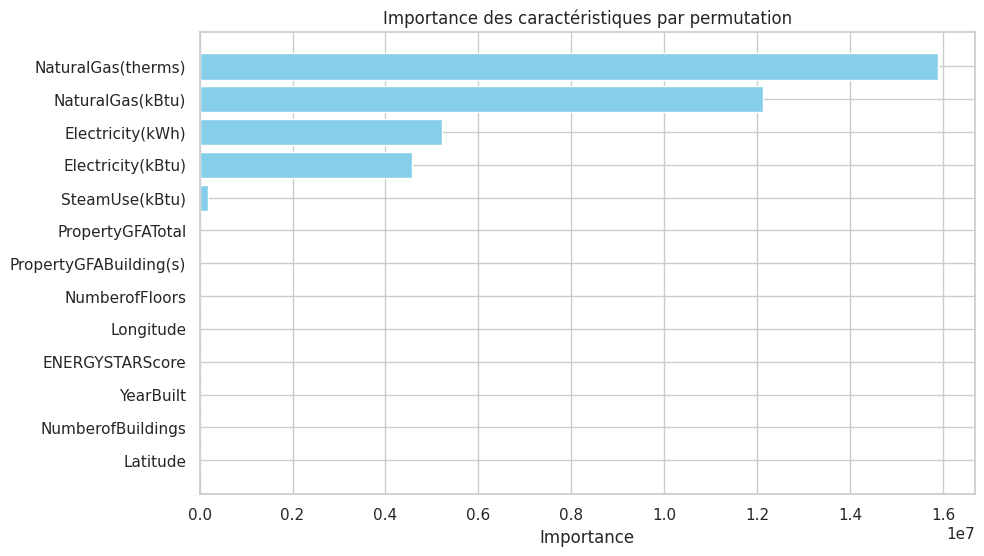

In [44]:
# Création d'un DataFrame pour afficher les importances par permutation
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

# Tri des importances par ordre décroissant
importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Affichage des résultats
print("Importance des caractéristiques par permutation :\n")
print(importance_df)

# Visualisation sous forme de graphique (optionnel)
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Importance des caractéristiques par permutation')
plt.gca().invert_yaxis()  # Inverser l'ordre des caractéristiques pour afficher les plus importantes en haut
plt.show()

## Chi²

In [45]:
X = df_clean.drop(columns=['TotalGHGEmissions'])  # Caractéristiques (variables indépendantes)
y = df_clean['TotalGHGEmissions']  # Variable cible (variable dépendante)

# Séparer les colonnes catégorielles et numériques
categorical_features = X.select_dtypes(include=['object', 'category']).columns

chi2_results = []

for feature_name in categorical_features:
    contingency_table = pd.crosstab(X[feature_name], y)
    if contingency_table.size == 0:
        continue  # Sauter les tables de contingence vides
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    chi2_results.append((feature_name, chi2, p_value))

# Créer un dataframe à partir des résultats du Chi2
chi2_df = pd.DataFrame(chi2_results, columns=['Feature', 'Chi2', 'p-value'])

# Afficher le dataframe avec les résultats
print(chi2_df)

               Feature          Chi2       p-value
0         BuildingType  21632.846488  4.583015e-21
1  PrimaryPropertyType  69897.214391  8.359167e-44
2         Neighborhood  33232.033811  9.864371e-01


# Modele tuning

## Custom transformer

In [46]:
class DropNaNTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = 'TotalGHGEmissions'

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if self.columns:
            return X.dropna(subset=self.columns)
        else:
            return X.dropna()

In [47]:
class LogTotalGHGEmissionsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        #X = X.dropna(subset=['TotalGHGEmissions'])
        
        # Exclusion des valeurs <= 0 et infinies
        #X = X[(X['TotalGHGEmissions'] > 0) & (~np.isnan(X['TotalGHGEmissions'])) & (~np.isinf(X['TotalGHGEmissions']))]
        
        # Calcul du logarithme
        X['log_TotalGHGEmissions'] = np.log(X['TotalGHGEmissions'])
        
        # Retourner uniquement la colonne transformée
        return X[['log_TotalGHGEmissions']]
    
# Utilisation du transformateur
transformer = LogTotalGHGEmissionsTransformer()
transformed_data = transformer.transform(df_clean)

print(transformed_data)

      log_TotalGHGEmissions
0                  5.521381
1                  5.689886
2                  7.644575
3                  5.657494
4                  6.224578
...                     ...
3371               3.041661
3372               3.471034
3373               5.409590
3374               3.096030
3375               3.720136

[3367 rows x 1 columns]


/home/louve/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/louve/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [48]:
if transformed_data.isnull().values.any():
    print("Le DataFrame contient au moins un NaN.")
else:
    print("Pas de NaN dans le DataFrame.")

Le DataFrame contient au moins un NaN.


In [49]:
# Définition de votre transformateur
class GroupPropertyTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, group_mapping, property_to_group_mapping):
        self.group_mapping = group_mapping
        self.property_to_group_mapping = property_to_group_mapping
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        # Vérifier les colonnes présentes dans X
        #print("Colonnes de X avant transformation :")
        #print(X.columns)
        
        # Transformation
        X['Group_Property'] = X['BuildingType'].map(self.group_mapping)
        X['Group_Property'] = X['PrimaryPropertyType'].map(self.property_to_group_mapping).fillna(X['Group_Property'])
        
        # Vérifier à nouveau les colonnes après transformation
        #print("Colonnes de X après transformation :")
        #print(X.columns)
        
        return X[['Group_Property']]

# Mappings pour le transformateur
group_mapping = {
    "Multifamily LR (1-4)": "Residence",
    "Multifamily MR (5-9)": "Residence",
    "Multifamily HR (10+)": "Residence",
    "SPS-District K-12": "Education",
    "Campus": "Education",
    "Nonresidential COS": "City-Owned Services",
    "Nonresidential WA": "Industrie",
    "NonResidential": "Mixed Use Property"
}

property_to_group_mapping = {
    'Hotel': 'Commerce',
    'Restaurant': 'Commerce',
    'Supermarket / Grocery Store': 'Commerce',
    'Retail Store': 'Commerce',
    'University': 'Education',
    'K-12 School': 'Education',
    'Self-Storage Facility': 'Industrie',
    'Warehouse': 'Industrie',
    'Refrigerated Warehouse': 'Industrie',
    'Distribution Center': 'Industrie',
    'Medical Office': 'Health',
    'Hospital': 'Health',
    'Senior Care Community': 'Health',
    'Laboratory': 'Health',
    'Small- and Mid-Sized Office': 'Office',
    'Large Office': 'Office',
    'Office': 'Office',
    'Worship Facility': 'Cult',
    'Other': 'Other'
}

# Utilisation du transformateur avec votre DataFrame data et ajout de la colonne transformée
transformer = GroupPropertyTransformer(group_mapping, property_to_group_mapping)
transformed_data = transformer.transform(df_clean)

# Affichage du DataFrame modifié
transformed_data

,Group_Property
0,Commerce
1,Commerce
2,Commerce
3,Commerce
4,Commerce
...,...
3371,Office
3372,Other
3373,Other
3374,City-Owned Services


In [50]:
if transformed_data.isnull().values.any():
    print("Le DataFrame contient au moins un NaN.")
else:
    print("Pas de NaN dans le DataFrame.")

Pas de NaN dans le DataFrame.


In [51]:
class ScoreClassifierTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, seuil_bas, seuil_moyen, seuil_eleve):
        self.seuil_bas = seuil_bas
        self.seuil_moyen = seuil_moyen
        self.seuil_eleve = seuil_eleve
    
    def fit(self, X, y=None):
        # Pas besoin de faire quelque chose dans fit pour ce transformateur
        return self
    
    def transform(self, X):
        X['Seuil'] = X['ENERGYSTARScore'].apply(self.classifier_score)
        return X[['Seuil']]
    
    def classifier_score(self, score):
        if score < self.seuil_bas:
            return 'Faible'
        elif score < self.seuil_moyen:
            return 'Moyen'
        elif score < self.seuil_eleve:
            return 'Élevé'
        else:
            return 'Très Élevé'

# Définition des seuils
seuil_bas = 50
seuil_moyen = 75
seuil_eleve = 90

# Initialisation et application du transformateur
transformer = ScoreClassifierTransformer(seuil_bas=seuil_bas, seuil_moyen=seuil_moyen, seuil_eleve=seuil_eleve)
transformer.fit(df_clean)
transformed_df = transformer.transform(df_clean)

# Affichage du résultat
print(transformed_df)

       Seuil
0      Moyen
1      Moyen
2     Faible
3      Moyen
4      Élevé
...      ...
3371  Faible
3372   Élevé
3373   Élevé
3374   Élevé
3375   Élevé

[3367 rows x 1 columns]


In [52]:
if transformed_df.isnull().values.any():
    print("Le DataFrame contient au moins un NaN.")
else:
    print("Pas de NaN dans le DataFrame.")

Pas de NaN dans le DataFrame.


## Pipeline

### transformer + encoding

In [53]:
numeric_features = ['NaturalGas(therms)', 'Electricity(kWh)', 'SteamUse(kBtu)', 'NumberofBuildings', 'TotalGHGEmissions', 'ENERGYSTARScore']

categorical_features = ['BuildingType', 'PrimaryPropertyType']

# Création des transformateurs pour les données numériques et catégorielles
numeric_transformer = Pipeline(steps=[
    ('num_imputer', KNNImputer()),
    ('scaler', RobustScaler())
])

categorical_transformer = Pipeline(steps=[
    ('cat_imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [54]:
categorical_transformer

Pipeline(steps=[('cat_imputer',
                 SimpleImputer(fill_value='missing', strategy='constant')),
                ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [55]:
numeric_transformer

Pipeline(steps=[('num_imputer', KNNImputer()), ('scaler', RobustScaler())])

In [56]:
X = df_clean.drop(columns=['TotalGHGEmissions'])

In [57]:
numeric_transformer.fit_transform(X[['NaturalGas(therms)', 'Electricity(kWh)', 'SteamUse(kBtu)', 'NumberofBuildings', 'ENERGYSTARScore']]).shape

(3367, 5)

In [58]:
nan_transformer = Pipeline([
    ('nan_remove', NansRemover()),
])

target_transformer = Pipeline([
    ('log_target', LogTotalGHGEmissionsTransformer()),
])

group_property = Pipeline([
    ('group_property', GroupPropertyTransformer(group_mapping, property_to_group_mapping)),
    ('ohe_encoder', OneHotEncoder())
])

class_emission = Pipeline([
    ('class_emission', ScoreClassifierTransformer(seuil_bas=seuil_bas, seuil_moyen=seuil_moyen, seuil_eleve=seuil_eleve)),
    ('oh_encoder', OneHotEncoder())
])

NameError: name 'NansRemover' is not defined

In [ ]:
target_transformer

In [ ]:
group_property

In [ ]:
class_emission

In [ ]:
transformer = GroupPropertyTransformer(group_mapping, property_to_group_mapping)
transformed_data = transformer.fit_transform(df_clean[['BuildingType', 'PrimaryPropertyType']])
transformed_data

In [ ]:
ohe = OneHotEncoder(handle_unknown='ignore')
new_m = ohe.fit_transform(transformed_data[['Group_Property']])
new_m.toarray()

In [ ]:
ohe.get_feature_names_out()

In [ ]:
new_m.shape

In [ ]:
group_property.fit(df_clean[['BuildingType', 'PrimaryPropertyType']])

In [ ]:
group_property.transform(df_clean[['BuildingType', 'PrimaryPropertyType']]).toarray()

In [ ]:
group_property.get_feature_names_out

In [ ]:
transformer = ScoreClassifierTransformer(seuil_bas=seuil_bas, seuil_moyen=seuil_moyen, seuil_eleve=seuil_eleve)
transformed_df = transformer.fit_transform(df_clean[['ENERGYSTARScore']])
transformed_df

In [ ]:
ohe_seuil = OneHotEncoder(handle_unknown='ignore')
new_s = ohe_seuil.fit_transform(transformed_df[['Seuil']])
new_s.toarray()

In [ ]:
ohe_seuil.get_feature_names_out()

In [ ]:
new_s.shape

In [ ]:
class_emission.fit(df_clean[['ENERGYSTARScore']])

In [ ]:
class_emission.transform(df_clean[['ENERGYSTARScore']]).toarray()

In [ ]:
class_emission.get_feature_names_out

### preprocessing

In [ ]:
numeric_features = ['NaturalGas(therms)', 'Electricity(kWh)', 'SteamUse(kBtu)', 'NumberofBuildings']

In [ ]:
categorical_features = ['BuildingType', 'PrimaryPropertyType']

categorical_features

In [ ]:
# Création des transformateurs pour les données numériques et catégorielles
numeric_transformer = Pipeline(steps=[
    ('num_imputer', KNNImputer()),
    ('scaler', RobustScaler())
])

categorical_transformer = Pipeline(steps=[
    ('cat_imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [ ]:
target_transformer = Pipeline([
    ('log_target', LogTotalGHGEmissionsTransformer()),
])

group_property = Pipeline([
    ('group_property', GroupPropertyTransformer(group_mapping, property_to_group_mapping)),
    ('ohe_encoder', OneHotEncoder())
])

class_emission = Pipeline([
    ('class_emission', ScoreClassifierTransformer(seuil_bas=seuil_bas, seuil_moyen=seuil_moyen, seuil_eleve=seuil_eleve)),
    ('oh_encoder', OneHotEncoder())
])

drop_nan = Pipeline([
    ('drop_nan', DropNaNTransformer())
])

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat_transformer', categorical_transformer, ['Neighborhood']),
        ('num_transformer', numeric_transformer, numeric_features),
        ('log_target', target_transformer, ['TotalGHGEmissions']),
        ('group_property', group_property, categorical_features),
        ('class_emission', class_emission, ['ENERGYSTARScore'])
    ],
    remainder='drop'
)

In [ ]:
preprocessor

In [ ]:
#transformed_data = preprocessor.fit(df_clean)

# Affichage des données transformées
#print(transformed_data)

### Modele

In [ ]:
X = df_clean[['NaturalGas(therms)', 'Electricity(kWh)', 'SteamUse(kBtu)', 'BuildingType', 'NumberofBuildings',
              'PrimaryPropertyType', 'Neighborhood', 'TotalGHGEmissions', 'ENERGYSTARScore']]
y = df_clean['TotalGHGEmissions']

In [ ]:
linear_pipe = Pipeline([
    #('drop_nan', DropNaNTransformer(columns=['TotalGHGEmissions'])),
    ('preprocessing', preprocessor),
    ('linear_regressor', LinearRegression())])
linear_pipe

In [ ]:
# Entraînement du modèle sur les données X et y
linear_pipe.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test (X_test)
y_pred = linear_pipe.predict(X_test)

# Évaluer le modèle
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse:.2f}')
print(f'R2: {r2:.2f}')

In [ ]:
cross_val = cross_val_score(linear_pipe, X, y, error_score='raise', cv=5)
print(cross_val)
cross_val_mean = cross_val.mean()
print(f'Cross-val : {cross_val_mean:.2f}')

In [ ]:
linear_pipe_trained = linear_pipe.fit(X_train, y_train)
linear_pipe_trained.get_params()

In [ ]:
grid_search = GridSearchCV(
    linear_pipe, 
    parameters = {
    'fit_intercept': [True, False],
    'normalize': [True, False]
}
    
grid_search = GridSearchCV(estimator=model, param_grid=parameters, scoring='neg_mean_squared_error', cv=5, verbose=1)
grid_search.fit(X_train, y_train)
grid_search.best_params_

In [ ]:
tuned_linear_pipe = grid_search.best_estimator_

In [ ]:
cross_val_score(tuned_linear_pipe, X_train, y_train, cv=5, scoring='r2').mean()

In [ ]:
# Export pipeline as pickle file
with open("tuned_linear_pipe.pkl", "wb") as file:
    pickle.dump(tuned_linear_pipe, file)

# Load pipeline from pickle file
my_pipeline = pickle.load(open("tuned_linear_pipe.pkl","rb"))

my_pipeline.score(X_test, y_test)